# Calibration Tutorial for Stock Market Analytics

This notebook demonstrates how to use the calibration capabilities in the model factory for post-hoc prediction processing.

## Overview

The main calibration components are:
1. **QuantileConformalCalibrator**: For prediction intervals with guaranteed coverage
2. **ConformalizedQuantileCalibrator**: For calibrated quantile predictions
3. **Calibration Functions**: Mathematical utilities for conformity scores and intervals

These calibrators provide:
- **Finite-sample coverage guarantees**: Marginal coverage under exchangeability
- **Distribution-free methods**: No assumptions about data distribution
- **Post-hoc calibration**: Can be applied to any base predictor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import calibration classes
from stock_market_analytics.modeling.model_factory.calibration.calibrators import (
    QuantileConformalCalibrator,
    ConformalizedQuantileCalibrator
)

# Import calibration functions
from stock_market_analytics.modeling.model_factory.calibration.calibration_functions import (
    conformity_abs_residuals,
    conformity_normalized_abs,
    finite_sample_quantile,
    symmetric_interval_from_radius,
)

# For creating synthetic data and models
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import polars as pl

## 1. Creating Sample Data with Heteroskedastic Noise

We'll create synthetic financial data that exhibits heteroskedastic noise (varying uncertainty), which is common in financial time series:

Dataset created with 2000 samples and 5 features
Target statistics: mean=-0.051, std=2.840
Noise volatility range: [0.516, 2.095]


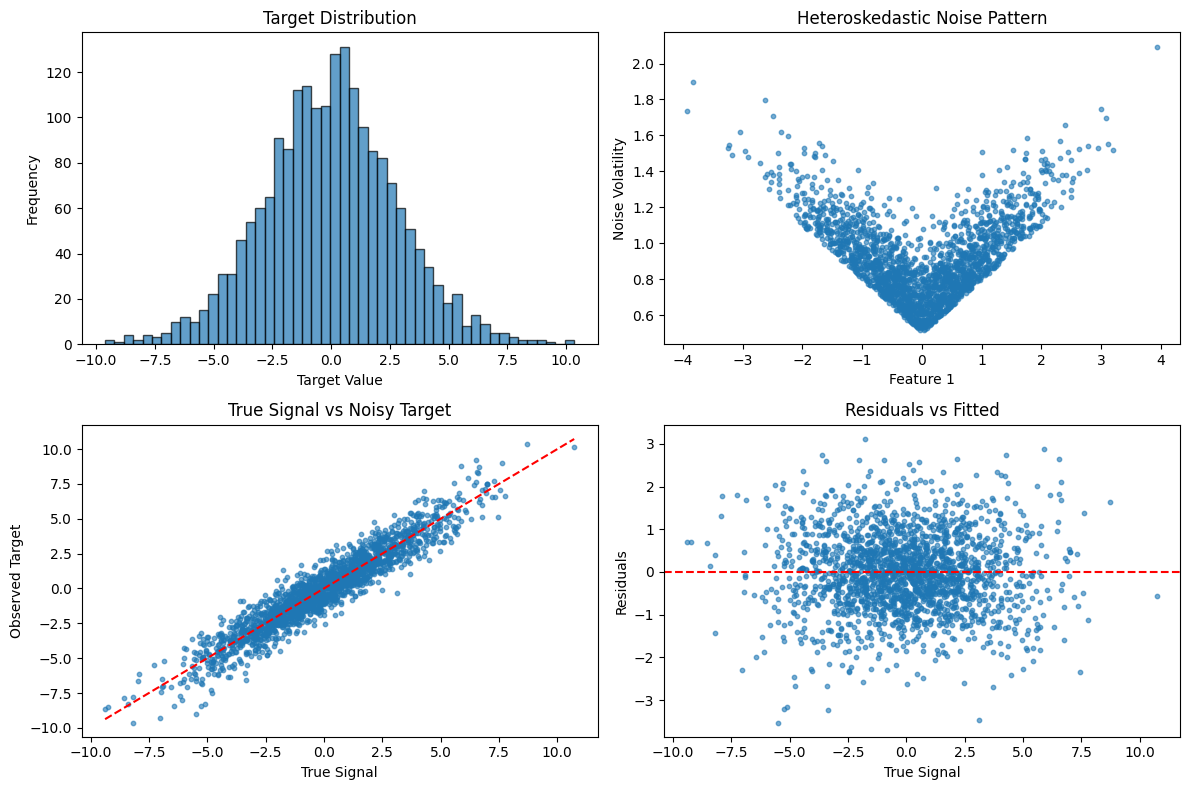

In [2]:
# Set seed for reproducibility
np.random.seed(42)

# Create synthetic financial data
n_samples = 2000
n_features = 5

# Generate features (e.g., technical indicators, market factors)
X = np.random.randn(n_samples, n_features)
feature_names = [f'feature_{i+1}' for i in range(n_features)]
X_df = pd.DataFrame(X, columns=feature_names)

# Create true function with non-linear relationships
true_signal = (
    2.0 * X[:, 0] +
    -1.5 * X[:, 1] +
    0.8 * X[:, 2] * X[:, 3] +  # Interaction term
    0.5 * np.sin(X[:, 4])      # Non-linear term
)

# Add heteroskedastic noise (volatility depends on features)
volatility = 0.5 + 0.3 * np.abs(X[:, 0]) + 0.2 * np.abs(X[:, 1])
noise = np.random.randn(n_samples) * volatility
y = true_signal + noise

print(f"Dataset created with {n_samples} samples and {n_features} features")
print(f"Target statistics: mean={y.mean():.3f}, std={y.std():.3f}")
print(f"Noise volatility range: [{volatility.min():.3f}, {volatility.max():.3f}]")

# Visualize the data
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Target distribution
axes[0, 0].hist(y, bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Target Distribution')
axes[0, 0].set_xlabel('Target Value')
axes[0, 0].set_ylabel('Frequency')

# Volatility vs first feature
axes[0, 1].scatter(X[:, 0], volatility, alpha=0.6, s=10)
axes[0, 1].set_title('Heteroskedastic Noise Pattern')
axes[0, 1].set_xlabel('Feature 1')
axes[0, 1].set_ylabel('Noise Volatility')

# Target vs predicted signal
axes[1, 0].scatter(true_signal, y, alpha=0.6, s=10)
axes[1, 0].plot([true_signal.min(), true_signal.max()], [true_signal.min(), true_signal.max()], 'r--')
axes[1, 0].set_title('True Signal vs Noisy Target')
axes[1, 0].set_xlabel('True Signal')
axes[1, 0].set_ylabel('Observed Target')

# Residuals vs fitted
residuals = y - true_signal
axes[1, 1].scatter(true_signal, residuals, alpha=0.6, s=10)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_title('Residuals vs Fitted')
axes[1, 1].set_xlabel('True Signal')
axes[1, 1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

## 2. Data Splitting for Calibration

For conformal prediction, we need three splits:
- **Training**: To fit the base model
- **Calibration**: To learn conformity scores
- **Test**: To evaluate final performance

In [3]:
# Split data: train (60%), calibration (20%), test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=42
)

X_train, X_cal, y_train, y_cal = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 overall
)

print("Data split sizes:")
print(f"  Training: {len(X_train)} samples ({len(X_train)/len(X_df)*100:.1f}%)")
print(f"  Calibration: {len(X_cal)} samples ({len(X_cal)/len(X_df)*100:.1f}%)")
print(f"  Test: {len(X_test)} samples ({len(X_test)/len(X_df)*100:.1f}%)")

# Convert to Polars Series for calibrators
y_cal_pl = pl.Series(y_cal)
y_test_pl = pl.Series(y_test)

Data split sizes:
  Training: 1200 samples (60.0%)
  Calibration: 400 samples (20.0%)
  Test: 400 samples (20.0%)


## 3. Training Base Models

We'll train different base models to demonstrate calibration on various prediction types:

In [4]:
# Train a point predictor (Random Forest)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get predictions on all splits
y_pred_train = rf_model.predict(X_train)
y_pred_cal = rf_model.predict(X_cal)
y_pred_test = rf_model.predict(X_test)

# Calculate prediction errors
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
cal_rmse = np.sqrt(mean_squared_error(y_cal, y_pred_cal))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Base model performance (RMSE):")
print(f"  Training: {train_rmse:.4f}")
print(f"  Calibration: {cal_rmse:.4f}")
print(f"  Test: {test_rmse:.4f}")

# Create synthetic quantile predictions for demonstration
# In practice, these would come from a quantile regression model
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

def create_synthetic_quantiles(y_point_pred, noise_level=1.0):
    """Create synthetic quantile predictions around point predictions."""
    n_samples = len(y_point_pred)
    quantile_preds = np.zeros((n_samples, len(quantiles)))
    
    for i, q in enumerate(quantiles):
        # Use normal approximation to create quantile predictions
        z_score = np.random.normal(0, 0.1, n_samples)  # Small random component
        quantile_preds[:, i] = y_point_pred + noise_level * (2 * (q - 0.5) + z_score)
    
    # Ensure monotonicity
    quantile_preds.sort(axis=1)
    return quantile_preds

y_quantiles_cal = create_synthetic_quantiles(y_pred_cal, noise_level=cal_rmse)
y_quantiles_test = create_synthetic_quantiles(y_pred_test, noise_level=test_rmse)

print(f"\nSynthetic quantile predictions created for calibration and test sets")
print(f"Calibration quantiles shape: {y_quantiles_cal.shape}")
print(f"Test quantiles shape: {y_quantiles_test.shape}")

Base model performance (RMSE):
  Training: 0.4740
  Calibration: 1.2654
  Test: 1.3073

Synthetic quantile predictions created for calibration and test sets
Calibration quantiles shape: (400, 5)
Test quantiles shape: (400, 5)


## 4. Conformal Prediction Intervals

Let's start with the `QuantileConformalCalibrator` for prediction intervals:

In [5]:
# Initialize conformal calibrator for 90% prediction intervals
alpha = 0.1  # 90% coverage
conformal_calibrator = QuantileConformalCalibrator(
    alpha=alpha,
    method="absolute"  # Could also use "normalized" with uncertainty estimates
)

# Fit calibrator using calibration set
conformal_calibrator.fit(
    X_cal=None,  # Not needed for this method
    y_cal=y_cal_pl,
    y_pred_cal=y_pred_cal
)

print(f"Conformal calibrator fitted")
print(f"Learned radius (conformity score quantile): {conformal_calibrator.radius_:.4f}")

# Generate prediction intervals for test set
intervals_test = conformal_calibrator.predict(y_pred_test)
lower_bounds = intervals_test[:, 0]
upper_bounds = intervals_test[:, 1]

# Calculate empirical coverage
coverage = np.mean((y_test >= lower_bounds) & (y_test <= upper_bounds))
interval_widths = upper_bounds - lower_bounds
mean_width = np.mean(interval_widths)

print(f"\nConformal Prediction Interval Results:")
print(f"  Target coverage: {1-alpha:.1%}")
print(f"  Empirical coverage: {coverage:.1%}")
print(f"  Mean interval width: {mean_width:.4f}")
print(f"  Coverage error: {abs(coverage - (1-alpha)):.3%}")

Conformal calibrator fitted
Learned radius (conformity score quantile): 2.0410

Conformal Prediction Interval Results:
  Target coverage: 90.0%
  Empirical coverage: 88.5%
  Mean interval width: 4.0821
  Coverage error: 1.500%


## 5. Visualizing Conformal Intervals

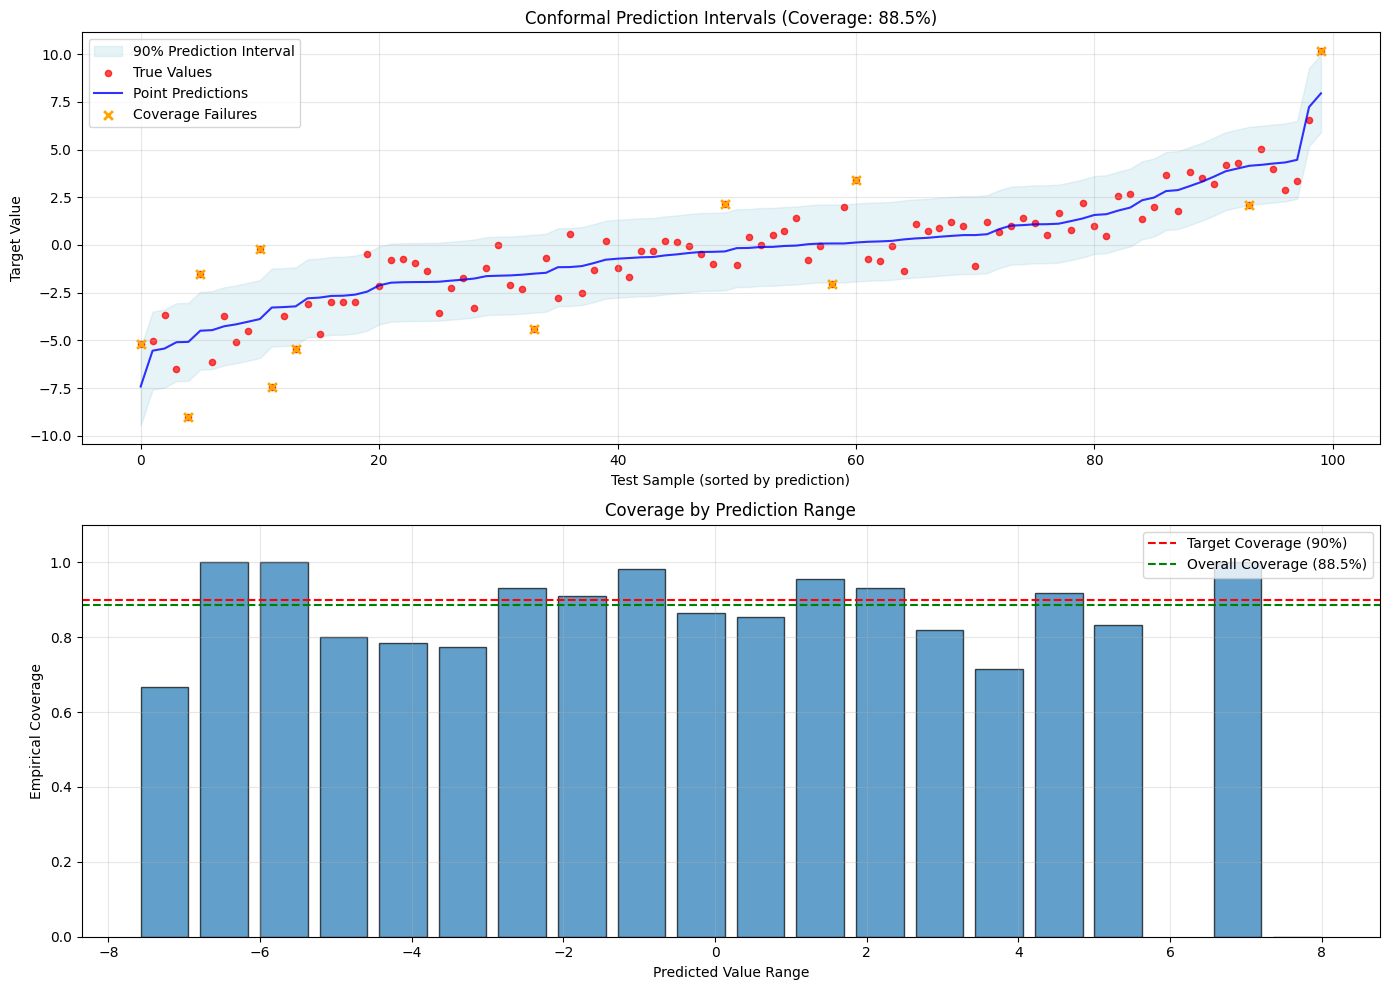


Coverage Analysis by Prediction Range:
  Bin 4 (pred ≈ -4.90): 80.0% coverage (10 samples)
  Bin 5 (pred ≈ -4.12): 78.6% coverage (14 samples)
  Bin 6 (pred ≈ -3.33): 77.3% coverage (22 samples)
  Bin 7 (pred ≈ -2.54): 93.1% coverage (29 samples)
  Bin 8 (pred ≈ -1.76): 90.9% coverage (44 samples)
  Bin 9 (pred ≈ -0.97): 98.3% coverage (58 samples)
  Bin 10 (pred ≈ -0.18): 86.5% coverage (52 samples)
  Bin 11 (pred ≈ 0.60): 85.4% coverage (41 samples)
  Bin 12 (pred ≈ 1.39): 95.5% coverage (44 samples)
  Bin 13 (pred ≈ 2.17): 93.1% coverage (29 samples)
  Bin 14 (pred ≈ 2.96): 81.8% coverage (22 samples)
  Bin 15 (pred ≈ 3.75): 71.4% coverage (7 samples)
  Bin 16 (pred ≈ 4.53): 91.7% coverage (12 samples)
  Bin 17 (pred ≈ 5.32): 83.3% coverage (6 samples)


In [6]:
# Select a subset of test points for visualization
n_viz = 100
viz_idx = np.random.choice(len(y_test), n_viz, replace=False)
viz_idx = np.sort(viz_idx)

y_test_viz = y_test[viz_idx]
y_pred_test_viz = y_pred_test[viz_idx]
lower_viz = lower_bounds[viz_idx]
upper_viz = upper_bounds[viz_idx]

# Sort by predicted values for better visualization
sort_idx = np.argsort(y_pred_test_viz)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Prediction intervals
x_points = np.arange(len(sort_idx))
ax1.fill_between(x_points, lower_viz[sort_idx], upper_viz[sort_idx], 
                alpha=0.3, color='lightblue', label=f'{1-alpha:.0%} Prediction Interval')
ax1.scatter(x_points, y_test_viz[sort_idx], alpha=0.7, color='red', s=20, label='True Values')
ax1.plot(x_points, y_pred_test_viz[sort_idx], 'b-', alpha=0.8, label='Point Predictions')

# Highlight coverage failures
coverage_mask = (y_test_viz >= lower_viz) & (y_test_viz <= upper_viz)
failures = ~coverage_mask[sort_idx]
if np.any(failures):
    ax1.scatter(x_points[failures], y_test_viz[sort_idx][failures], 
               color='orange', s=40, marker='x', label='Coverage Failures', linewidth=2)

ax1.set_title(f'Conformal Prediction Intervals (Coverage: {coverage:.1%})')
ax1.set_xlabel('Test Sample (sorted by prediction)')
ax1.set_ylabel('Target Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Coverage analysis
# Bin predictions and calculate coverage per bin
n_bins = 20
pred_bins = np.linspace(y_pred_test.min(), y_pred_test.max(), n_bins + 1)
bin_centers = (pred_bins[:-1] + pred_bins[1:]) / 2
coverage_per_bin = []
counts_per_bin = []

for i in range(n_bins):
    mask = (y_pred_test >= pred_bins[i]) & (y_pred_test < pred_bins[i + 1])
    if i == n_bins - 1:  # Include the last point
        mask |= (y_pred_test == pred_bins[i + 1])
    
    if np.any(mask):
        bin_coverage = np.mean((y_test[mask] >= lower_bounds[mask]) & 
                              (y_test[mask] <= upper_bounds[mask]))
        coverage_per_bin.append(bin_coverage)
        counts_per_bin.append(np.sum(mask))
    else:
        coverage_per_bin.append(np.nan)
        counts_per_bin.append(0)

coverage_per_bin = np.array(coverage_per_bin)
counts_per_bin = np.array(counts_per_bin)

# Plot coverage per bin
valid_bins = ~np.isnan(coverage_per_bin)
ax2.bar(bin_centers[valid_bins], coverage_per_bin[valid_bins], 
       width=np.diff(pred_bins)[0] * 0.8, alpha=0.7, edgecolor='black')
ax2.axhline(y=1-alpha, color='red', linestyle='--', label=f'Target Coverage ({1-alpha:.0%})')
ax2.axhline(y=coverage, color='green', linestyle='--', label=f'Overall Coverage ({coverage:.1%})')

ax2.set_title('Coverage by Prediction Range')
ax2.set_xlabel('Predicted Value Range')
ax2.set_ylabel('Empirical Coverage')
ax2.set_ylim(0, 1.1)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print coverage statistics
print("\nCoverage Analysis by Prediction Range:")
for i, (center, cov, count) in enumerate(zip(bin_centers, coverage_per_bin, counts_per_bin)):
    if not np.isnan(cov) and count > 5:  # Only show bins with sufficient samples
        print(f"  Bin {i+1} (pred ≈ {center:.2f}): {cov:.1%} coverage ({count} samples)")

## 6. Conformalized Quantile Calibration

Now let's use the `ConformalizedQuantileCalibrator` for calibrated quantile predictions:

In [7]:
# Initialize conformalized quantile calibrator
quantile_calibrator = ConformalizedQuantileCalibrator(
    quantiles=quantiles,
    enforce_monotonic=True
)

# Fit calibrator using calibration set
quantile_calibrator.fit(
    X_cal=None,  # Not needed for this method
    y_cal=y_cal_pl,
    y_pred_cal_quantiles=y_quantiles_cal
)

print(f"Quantile calibrator fitted with {len(quantiles)} quantiles")
print(f"Learned shifts: {quantile_calibrator.shifts_}")

# Generate calibrated quantile predictions for test set
y_quantiles_calibrated = quantile_calibrator.predict_quantiles(y_quantiles_test)

# Also get 90% prediction intervals from calibrated quantiles
intervals_from_quantiles = quantile_calibrator.predict(y_quantiles_test, alpha=0.1)
lower_quantile = intervals_from_quantiles[:, 0]
upper_quantile = intervals_from_quantiles[:, 1]

print(f"\nCalibrated quantiles shape: {y_quantiles_calibrated.shape}")
print(f"Intervals from quantiles shape: {intervals_from_quantiles.shape}")

Quantile calibrator fitted with 5 quantiles
Learned shifts: [-0.48666276 -0.22721111 -0.05123259  0.10583277  0.4308513 ]

Calibrated quantiles shape: (400, 5)
Intervals from quantiles shape: (400, 2)


## 7. Quantile Calibration Analysis

Quantile Coverage Analysis:
Quantile   Target   Before   After    Error Before Error After 
10.0%      10.0%    17.2%    9.2%     7.250%       0.750%      
25.0%      25.0%    28.7%    22.5%    3.750%       2.500%      
50.0%      50.0%    51.0%    49.0%    1.000%       1.000%      
75.0%      75.0%    72.2%    76.0%    2.750%       1.000%      
90.0%      90.0%    82.2%    88.2%    7.750%       1.750%      
Mean Error          4.500%   1.400%                
Max Error           7.750%   2.500%                


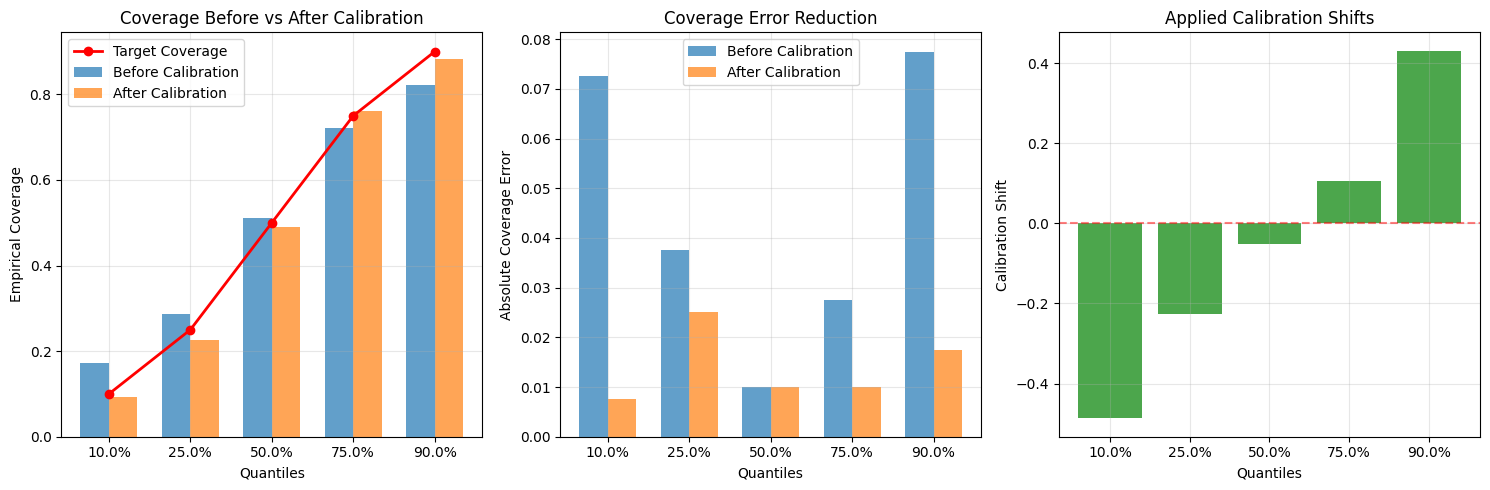

In [8]:
# Calculate coverage for each quantile before and after calibration
def calculate_quantile_coverage(y_true, y_quantiles, quantiles):
    """Calculate empirical coverage for each quantile."""
    coverage = []
    for i, q in enumerate(quantiles):
        empirical_coverage = np.mean(y_true <= y_quantiles[:, i])
        coverage.append(empirical_coverage)
    return np.array(coverage)

# Before calibration
coverage_before = calculate_quantile_coverage(y_test, y_quantiles_test, quantiles)

# After calibration
coverage_after = calculate_quantile_coverage(y_test, y_quantiles_calibrated, quantiles)

# Coverage errors
errors_before = np.abs(coverage_before - quantiles)
errors_after = np.abs(coverage_after - quantiles)

print("Quantile Coverage Analysis:")
print("=" * 60)
print(f"{'Quantile':<10} {'Target':<8} {'Before':<8} {'After':<8} {'Error Before':<12} {'Error After':<12}")
print("=" * 60)

for i, q in enumerate(quantiles):
    print(f"{q:<10.1%} {q:<8.1%} {coverage_before[i]:<8.1%} {coverage_after[i]:<8.1%} "
          f"{errors_before[i]:<12.3%} {errors_after[i]:<12.3%}")

print("=" * 60)
print(f"{'Mean Error':<10} {'':<8} {np.mean(errors_before):<8.3%} {np.mean(errors_after):<8.3%} "
      f"{'':<12} {''}")
print(f"{'Max Error':<10} {'':<8} {np.max(errors_before):<8.3%} {np.max(errors_after):<8.3%} "
      f"{'':<12} {''}")

# Visualize calibration improvement
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Coverage comparison
x_pos = np.arange(len(quantiles))
width = 0.35

ax1.bar(x_pos - width/2, coverage_before, width, label='Before Calibration', alpha=0.7)
ax1.bar(x_pos + width/2, coverage_after, width, label='After Calibration', alpha=0.7)
ax1.plot(x_pos, quantiles, 'ro-', label='Target Coverage', linewidth=2)

ax1.set_xlabel('Quantiles')
ax1.set_ylabel('Empirical Coverage')
ax1.set_title('Coverage Before vs After Calibration')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'{q:.1%}' for q in quantiles])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Coverage errors
ax2.bar(x_pos - width/2, errors_before, width, label='Before Calibration', alpha=0.7)
ax2.bar(x_pos + width/2, errors_after, width, label='After Calibration', alpha=0.7)

ax2.set_xlabel('Quantiles')
ax2.set_ylabel('Absolute Coverage Error')
ax2.set_title('Coverage Error Reduction')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'{q:.1%}' for q in quantiles])
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Calibration shifts applied
ax3.bar(x_pos, quantile_calibrator.shifts_, alpha=0.7, color='green')
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax3.set_xlabel('Quantiles')
ax3.set_ylabel('Calibration Shift')
ax3.set_title('Applied Calibration Shifts')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'{q:.1%}' for q in quantiles])
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Comparing Different Calibration Methods


Comparison of 90% Prediction Intervals:
Method                    Coverage   Mean Width   Median Width
Conformal (Point-based)   88.5%      4.0821       4.0821      
Conformal (Quantile-based) 79.0%      3.0128       3.0108      


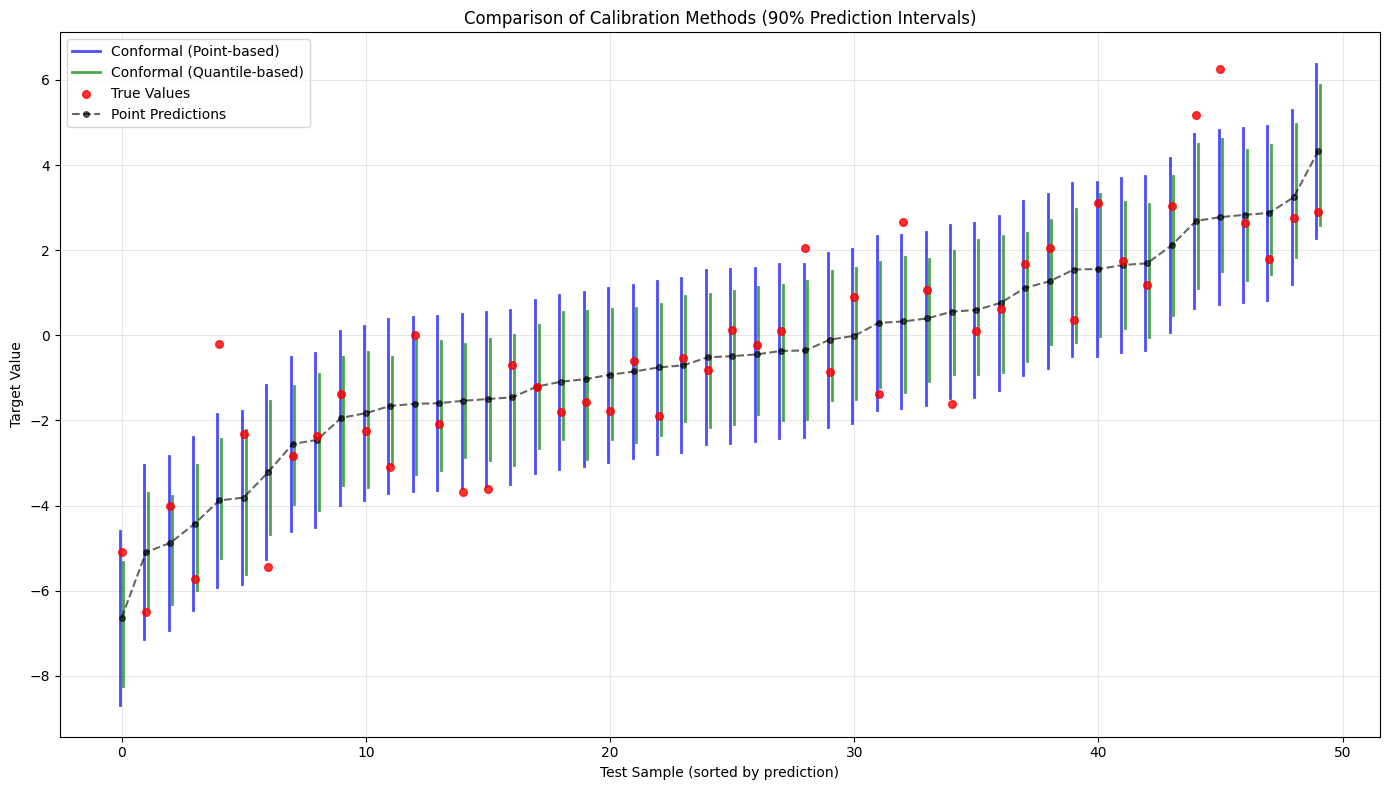

In [9]:
# Compare intervals from different methods
methods_comparison = {
    'Conformal (Point-based)': {
        'lower': lower_bounds,
        'upper': upper_bounds,
        'color': 'blue'
    },
    'Conformal (Quantile-based)': {
        'lower': lower_quantile,
        'upper': upper_quantile,
        'color': 'green'
    }
}

# Calculate metrics for each method
print("\nComparison of 90% Prediction Intervals:")
print("=" * 70)
print(f"{'Method':<25} {'Coverage':<10} {'Mean Width':<12} {'Median Width':<12}")
print("=" * 70)

for method_name, method_data in methods_comparison.items():
    lower = method_data['lower']
    upper = method_data['upper']
    
    coverage = np.mean((y_test >= lower) & (y_test <= upper))
    widths = upper - lower
    mean_width = np.mean(widths)
    median_width = np.median(widths)
    
    print(f"{method_name:<25} {coverage:<10.1%} {mean_width:<12.4f} {median_width:<12.4f}")

print("=" * 70)

# Visualize comparison on a subset
n_compare = 50
compare_idx = np.random.choice(len(y_test), n_compare, replace=False)
compare_idx = np.sort(compare_idx)

fig, ax = plt.subplots(figsize=(14, 8))

x_points = np.arange(len(compare_idx))
sort_idx = np.argsort(y_pred_test[compare_idx])

# Plot intervals for each method
for i, (method_name, method_data) in enumerate(methods_comparison.items()):
    lower = method_data['lower'][compare_idx][sort_idx]
    upper = method_data['upper'][compare_idx][sort_idx]
    color = method_data['color']
    
    # Offset x-coordinates for better visibility
    x_offset = x_points + (i - 0.5) * 0.15
    
    for j in range(len(x_offset)):
        ax.plot([x_offset[j], x_offset[j]], [lower[j], upper[j]], 
               color=color, alpha=0.7, linewidth=2, 
               label=method_name if j == 0 else "")

# Plot true values and predictions
ax.scatter(x_points, y_test[compare_idx][sort_idx], color='red', s=30, 
          alpha=0.8, label='True Values', zorder=5)
ax.plot(x_points, y_pred_test[compare_idx][sort_idx], 'ko--', 
       alpha=0.6, label='Point Predictions', markersize=4)

ax.set_title('Comparison of Calibration Methods (90% Prediction Intervals)')
ax.set_xlabel('Test Sample (sorted by prediction)')
ax.set_ylabel('Target Value')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Advanced Calibration: Normalized Method

For heteroskedastic data, the normalized method can provide better calibration by using uncertainty estimates:

In [10]:
# Estimate prediction uncertainties (in practice, these might come from model)
# For demonstration, we'll use the residual standard deviation as proxy
def estimate_prediction_uncertainty(X, model, n_bootstrap=50):
    """Estimate prediction uncertainty using bootstrap."""
    predictions = []
    
    # Simple bootstrap approach
    for _ in range(n_bootstrap):
        # Add small noise to features to simulate uncertainty
        X_noisy = X + np.random.normal(0, 0.01, X.shape)
        pred = model.predict(X_noisy)
        predictions.append(pred)
    
    predictions = np.array(predictions)
    uncertainty = np.std(predictions, axis=0)
    return uncertainty

# Estimate uncertainties
print("Estimating prediction uncertainties...")
y_std_cal = estimate_prediction_uncertainty(X_cal, rf_model)
y_std_test = estimate_prediction_uncertainty(X_test, rf_model)

print(f"Uncertainty statistics:")
print(f"  Calibration: mean={y_std_cal.mean():.4f}, std={y_std_cal.std():.4f}")
print(f"  Test: mean={y_std_test.mean():.4f}, std={y_std_test.std():.4f}")

# Fit normalized conformal calibrator
normalized_calibrator = QuantileConformalCalibrator(
    alpha=alpha,
    method="normalized"
)

normalized_calibrator.fit(
    X_cal=None,
    y_cal=y_cal_pl,
    y_pred_cal=y_pred_cal,
    y_std_cal=y_std_cal
)

print(f"\nNormalized calibrator fitted")
print(f"Learned radius: {normalized_calibrator.radius_:.4f}")

# Generate normalized intervals
intervals_normalized = normalized_calibrator.predict(y_pred_test, y_std=y_std_test)
lower_normalized = intervals_normalized[:, 0]
upper_normalized = intervals_normalized[:, 1]

# Calculate metrics
coverage_normalized = np.mean((y_test >= lower_normalized) & (y_test <= upper_normalized))
widths_normalized = upper_normalized - lower_normalized
mean_width_normalized = np.mean(widths_normalized)

print(f"\nNormalized Conformal Results:")
print(f"  Target coverage: {1-alpha:.1%}")
print(f"  Empirical coverage: {coverage_normalized:.1%}")
print(f"  Mean interval width: {mean_width_normalized:.4f}")
print(f"  Coverage error: {abs(coverage_normalized - (1-alpha)):.3%}")

Estimating prediction uncertainties...
Uncertainty statistics:
  Calibration: mean=0.0564, std=0.0404
  Test: mean=0.0532, std=0.0400

Normalized calibrator fitted
Learned radius: 59.0909

Normalized Conformal Results:
  Target coverage: 90.0%
  Empirical coverage: 87.2%
  Mean interval width: 6.2905
  Coverage error: 2.750%


## 10. Adaptive Width Analysis

Let's analyze how the different methods adapt to varying uncertainty:

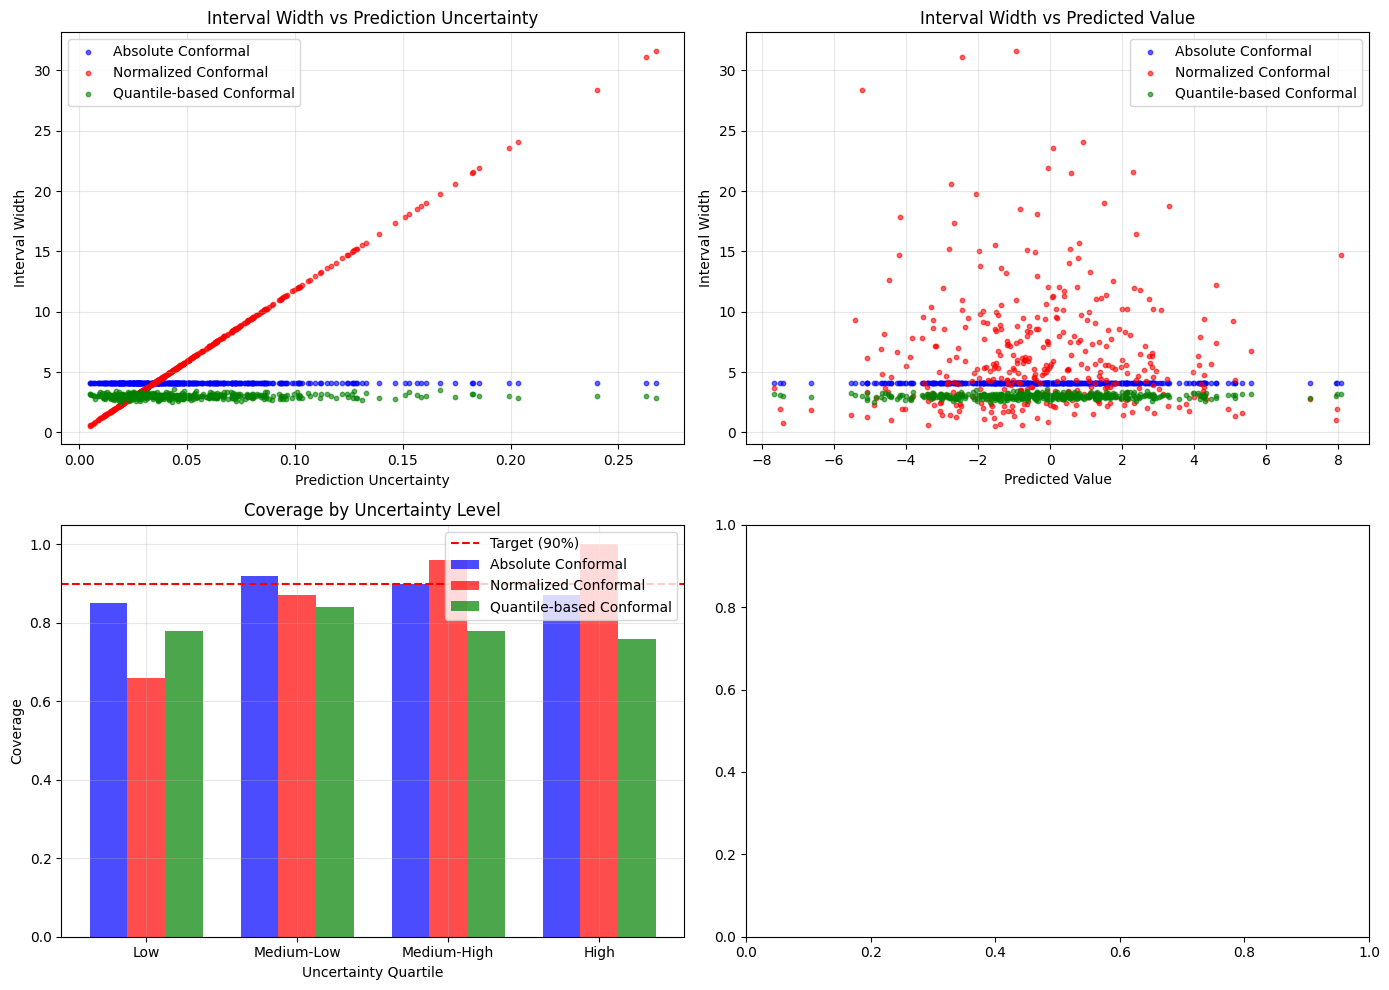


Coverage by Uncertainty Quartile:
Quartile        Absolute     Normalized   Quantile-based 
Low             85.0%        66.0%        78.0%          
Medium-Low      92.0%        87.0%        84.0%          
Medium-High     90.0%        96.0%        78.0%          
High            87.0%        100.0%       76.0%          


In [20]:
# Analyze interval widths vs prediction uncertainty
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get all interval types
all_methods = {
    'Absolute Conformal': (lower_bounds, upper_bounds, 'blue'),
    'Normalized Conformal': (lower_normalized, upper_normalized, 'red'),
    'Quantile-based Conformal': (lower_quantile, upper_quantile, 'green')
}

# Plot 1: Width vs prediction uncertainty
for i, (name, (lower, upper, color)) in enumerate(all_methods.items()):
    widths = upper - lower
    axes[0, 0].scatter(y_std_test, widths, alpha=0.6, s=10, color=color, label=name)

axes[0, 0].set_xlabel('Prediction Uncertainty')
axes[0, 0].set_ylabel('Interval Width')
axes[0, 0].set_title('Interval Width vs Prediction Uncertainty')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Width vs prediction value
for name, (lower, upper, color) in all_methods.items():
    widths = upper - lower
    axes[0, 1].scatter(y_pred_test, widths, alpha=0.6, s=10, color=color, label=name)

axes[0, 1].set_xlabel('Predicted Value')
axes[0, 1].set_ylabel('Interval Width')
axes[0, 1].set_title('Interval Width vs Predicted Value')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Coverage by uncertainty quartiles
uncertainty_quartiles = np.percentile(y_std_test, [25, 50, 75])
quartile_labels = ['Low', 'Medium-Low', 'Medium-High', 'High']

coverage_by_quartile = {name: [] for name in all_methods.keys()}

for i in range(4):
    if i == 0:
        mask = y_std_test <= uncertainty_quartiles[0]
    elif i == 3:
        mask = y_std_test > uncertainty_quartiles[2]
    else:
        mask = (y_std_test > uncertainty_quartiles[i-1]) & (y_std_test <= uncertainty_quartiles[i])
    
    if np.any(mask):
        for name, (lower, upper, color) in all_methods.items():
            coverage = np.mean((y_test[mask] >= lower[mask]) & (y_test[mask] <= upper[mask]))
            coverage_by_quartile[name].append(coverage)
    else:
        for name in all_methods.keys():
            coverage_by_quartile[name].append(np.nan)

x_quartiles = np.arange(len(quartile_labels))
width = 0.25
for i, (name, coverages) in enumerate(coverage_by_quartile.items()):
    color = all_methods[name][2]
    axes[1, 0].bar(x_quartiles + i * width, coverages, width, 
                  label=name, alpha=0.7, color=color)

axes[1, 0].axhline(y=1-alpha, color='red', linestyle='--', label=f'Target ({1-alpha:.0%})')
axes[1, 0].set_xlabel('Uncertainty Quartile')
axes[1, 0].set_ylabel('Coverage')
axes[1, 0].set_title('Coverage by Uncertainty Level')
axes[1, 0].set_xticks(x_quartiles + width)
axes[1, 0].set_xticklabels(quartile_labels)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# # Plot 4: Width distributions
# for name, (lower, upper, color) in all_methods.items():
#     widths = upper - lower
#     axes[1, 1].hist(widths, bins=1, alpha=0.6, label=name, color=color, density=True)

# axes[1, 1].set_xlabel('Interval Width')
# axes[1, 1].set_ylabel('Density')
# axes[1, 1].set_title('Distribution of Interval Widths')
# axes[1, 1].legend()
# axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print coverage by uncertainty quartile
print("\nCoverage by Uncertainty Quartile:")
print("=" * 60)
print(f"{'Quartile':<15} {'Absolute':<12} {'Normalized':<12} {'Quantile-based':<15}")
print("=" * 60)

for i, quartile in enumerate(quartile_labels):
    abs_cov = coverage_by_quartile['Absolute Conformal'][i]
    norm_cov = coverage_by_quartile['Normalized Conformal'][i]
    quant_cov = coverage_by_quartile['Quantile-based Conformal'][i]
    
    print(f"{quartile:<15} {abs_cov:<12.1%} {norm_cov:<12.1%} {quant_cov:<15.1%}")

print("=" * 60)

## 11. Summary and Best Practices

### Key Takeaways:

1. **Conformal Prediction provides finite-sample guarantees** - Unlike asymptotic methods, conformal prediction provides exact coverage guarantees for any finite sample size under exchangeability.

2. **Method Selection**:
   - **Absolute method**: Simple, works well with homoskedastic errors
   - **Normalized method**: Better for heteroskedastic data when uncertainty estimates are available
   - **Quantile-based**: More flexible, can capture complex distributional features

3. **Trade-offs**:
   - **Coverage vs Width**: More conservative calibration → wider intervals
   - **Adaptivity vs Simplicity**: Normalized methods adapt to local uncertainty but require good uncertainty estimates

### Best Practices:

1. **Always use a separate calibration set** - Never calibrate on training or test data
2. **Check coverage across different regions** - Ensure marginal coverage holds locally
3. **Consider the base model quality** - Better base models typically need smaller calibration adjustments
4. **Monitor calibration over time** - In non-stationary environments, recalibration may be needed
5. **Use multiple methods for comparison** - Different methods may perform better in different scenarios

In [12]:
# Final summary statistics
print("FINAL CALIBRATION SUMMARY")
print("=" * 50)

print(f"Dataset: {len(y)} total samples")
print(f"  Training: {len(X_train)} ({len(X_train)/len(y)*100:.1f}%)")
print(f"  Calibration: {len(X_cal)} ({len(X_cal)/len(y)*100:.1f}%)")
print(f"  Test: {len(X_test)} ({len(X_test)/len(y)*100:.1f}%)")

print(f"\nBase Model (Random Forest):")
print(f"  Test RMSE: {test_rmse:.4f}")

print(f"\nCalibration Results (Target: {1-alpha:.0%} coverage):")
print(f"  Absolute Conformal: {coverage:.1%} coverage, {mean_width:.3f} avg width")
print(f"  Normalized Conformal: {coverage_normalized:.1%} coverage, {mean_width_normalized:.3f} avg width")

coverage_quantile = np.mean((y_test >= lower_quantile) & (y_test <= upper_quantile))
width_quantile = np.mean(upper_quantile - lower_quantile)
print(f"  Quantile Conformal: {coverage_quantile:.1%} coverage, {width_quantile:.3f} avg width")

print(f"\nQuantile Calibration Improvement:")
print(f"  Mean coverage error before: {np.mean(errors_before):.3%}")
print(f"  Mean coverage error after: {np.mean(errors_after):.3%}")
print(f"  Improvement: {(np.mean(errors_before) - np.mean(errors_after))/np.mean(errors_before)*100:.1f}%")

print("\n✅ Calibration tutorial completed successfully!")

FINAL CALIBRATION SUMMARY
Dataset: 2000 total samples
  Training: 1200 (60.0%)
  Calibration: 400 (20.0%)
  Test: 400 (20.0%)

Base Model (Random Forest):
  Test RMSE: 1.3073

Calibration Results (Target: 90% coverage):
  Absolute Conformal: 76.0% coverage, 3.013 avg width
  Normalized Conformal: 87.2% coverage, 6.291 avg width
  Quantile Conformal: 79.0% coverage, 3.013 avg width

Quantile Calibration Improvement:
  Mean coverage error before: 4.500%
  Mean coverage error after: 1.400%
  Improvement: 68.9%

✅ Calibration tutorial completed successfully!
